# Word Embedding Evaluation

This notebook explores and compares different word embedding models:
- **PPMI-SVD**: Count-based embeddings using PPMI and matrix factorization
- **Word2Vec (Skip-Gram)**: Neural embeddings using negative sampling

In [114]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

from src.embeddings.PPMI_SVD import PPMI_SVD
from src.embeddings.Word2Vec import Word2Vec

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

## Load Models

In [115]:
# Load PPMI-SVD
print("Loading PPMI-SVD model...")
ppmi_model = PPMI_SVD.load(Path("../models/embeddings/ppmi_svd.pkl"))
print(f"  Vocab size: {len(ppmi_model.word2idx):,}")
print(f"  Embedding dim: {ppmi_model.embedding_dim}")

# Load Word2Vec
print("\nLoading Word2Vec model...")
w2v_model = Word2Vec.load(Path("../models/embeddings/word2vec.pkl"))
print(f"  Vocab size: {w2v_model.vocab_size:,}")
print(f"  Embedding dim: {w2v_model.embedding_dim}")

Loading PPMI-SVD model...
Imported vocabulary: 41,958 words (excluding special tokens)
  Vocab size: 41,958
  Embedding dim: 300

Loading Word2Vec model...
  Vocab size: 41,962
  Embedding dim: 300


## 1. Similarity Queries

Find most similar words for various queries.

In [116]:
# Test words
test_words = ["king", "woman", "city", "good", "computer", "war"]

for word in test_words:
    print(f"\n{'='*70}")
    print(f"Query: '{word}'")
    print(f"{'='*70}")
    
    # PPMI-SVD
    if word in ppmi_model.word2idx:
        similar_ppmi = ppmi_model.most_similar(word, top_k=5)
        print("\nPPMI-SVD:")
        for w, score in similar_ppmi:
            print(f"  {w:20s} {score:.4f}")
    else:
        print(f"\nPPMI-SVD: '{word}' not in vocabulary")
    
    # Word2Vec
    if word in w2v_model.tokenizer.word2idx:
        word_idx = w2v_model.tokenizer.word2idx[word]
        similar_w2v = w2v_model.most_similar(word_idx, top_k=5)
        print("\nWord2Vec:")
        for idx, score in similar_w2v:
            w = w2v_model.tokenizer.idx2word[idx]
            print(f"  {w:20s} {score:.4f}")
    else:
        print(f"\nWord2Vec: '{word}' not in vocabulary")


Query: 'king'

PPMI-SVD:
  queen                0.6189
  prince               0.6128
  reigning             0.6107
  majesty              0.6094
  throne               0.5982

Word2Vec:
  emperor              0.8843
  judah                0.8706
  jehovah              0.8694
  jacob                0.8665
  matthew              0.8593

Query: 'woman'

PPMI-SVD:
  girl                 0.7132
  man                  0.6407
  guy                  0.5320
  husband              0.5290
  mother               0.5024

Word2Vec:
  grandparents         0.8693
  grandchildren        0.8663
  affair               0.8627
  husbands             0.8615
  beggar               0.8606

Query: 'city'

PPMI-SVD:
  v1                   0.4914
  v4                   0.4826
  town                 0.4692
  v2                   0.4629
  kansas               0.4539

Word2Vec:
  cathedral            0.7747
  heights              0.7733
  v4                   0.7684
  valley               0.7576
  v1              

## 2. Word Analogies

Test classic word analogies: "A is to B as C is to ?"

In [117]:
# Define analogies: (a, b, c) → ?
# "a is to b as c is to ?"
analogies = [
    ("king", "man", "woman"),      # king - man + woman = queen
    ("paris", "france", "germany"), # paris - france + germany = berlin
    ("good", "better", "bad"),     # good - better + bad = worse
]

for a, b, c in analogies:
    print(f"\n{'='*70}")
    print(f"Analogy: '{a}' is to '{b}' as '{c}' is to ?")
    print(f"{'='*70}")
    
    # PPMI-SVD
    if all(w in ppmi_model.word2idx for w in [a, b, c]):
        a_vec = ppmi_model.get_embedding(a)
        b_vec = ppmi_model.get_embedding(b)
        c_vec = ppmi_model.get_embedding(c)
        
        exclude = {ppmi_model.word2idx[w] for w in [a, b, c]}
        results = ppmi_model.analogy(
            positive=[a_vec, c_vec],
            negative=[b_vec],
            embeddings=ppmi_model.embeddings,
            top_k=3,
            exclude_indices=exclude
        )
        
        print("\nPPMI-SVD:")
        for idx, score in results:
            print(f"  {ppmi_model.idx2word[idx]:20s} {score:.4f}")
    else:
        print("\nPPMI-SVD: Not all words in vocabulary")
    
    # Word2Vec
    if all(w in w2v_model.tokenizer.word2idx for w in [a, b, c]):
        a_idx = w2v_model.tokenizer.word2idx[a]
        b_idx = w2v_model.tokenizer.word2idx[b]
        c_idx = w2v_model.tokenizer.word2idx[c]
        
        a_vec = w2v_model.get_embedding(a_idx)
        b_vec = w2v_model.get_embedding(b_idx)
        c_vec = w2v_model.get_embedding(c_idx)
        
        exclude = {a_idx, b_idx, c_idx}
        results = w2v_model.analogy(
            positive=[a_vec, c_vec],
            negative=[b_vec],
            embeddings=w2v_model.W,
            top_k=3,
            exclude_indices=exclude
        )
        
        print("\nWord2Vec:")
        for idx, score in results:
            print(f"  {w2v_model.tokenizer.idx2word[idx]:20s} {score:.4f}")
    else:
        print("\nWord2Vec: Not all words in vocabulary")


Analogy: 'king' is to 'man' as 'woman' is to ?

PPMI-SVD:
  queen                0.6097
  majesty              0.5533
  reigning             0.5081

Word2Vec:
  throne               0.8224
  jehovah              0.8177
  judah                0.8134

Analogy: 'paris' is to 'france' as 'germany' is to ?

PPMI-SVD:
  berlin               0.7293
  munich               0.5160
  hamburg              0.5120

Word2Vec:
  berlin               0.8008
  cardiff              0.7684
  munich               0.7432

Analogy: 'good' is to 'better' as 'bad' is to ?

PPMI-SVD:
  nice                 0.4759
  yeah                 0.4398
  funny                0.4329

Word2Vec:
  apparently           0.6769
  awful                0.6674
  talked               0.6656


## 3. Visualization: Word Clusters

Visualize embeddings of selected words in 2D using PCA.

In [118]:
# Select words to visualize
words_to_plot = [
    # Countries
    "france", "germany", "italy", "spain", "england",
    # Cities
    "paris", "berlin", "rome", "madrid", "london",
    # Animals
    "cat", "dog", "horse", "lion", "tiger",
    # Food
    "apple", "banana", "bread", "cheese", "wine",
]

# Filter to words in both vocabularies
valid_words = [
    w for w in words_to_plot 
    if w in ppmi_model.word2idx and w in w2v_model.tokenizer.word2idx
]

print(f"Visualizing {len(valid_words)} words: {', '.join(valid_words)}")

Visualizing 20 words: france, germany, italy, spain, england, paris, berlin, rome, madrid, london, cat, dog, horse, lion, tiger, apple, banana, bread, cheese, wine


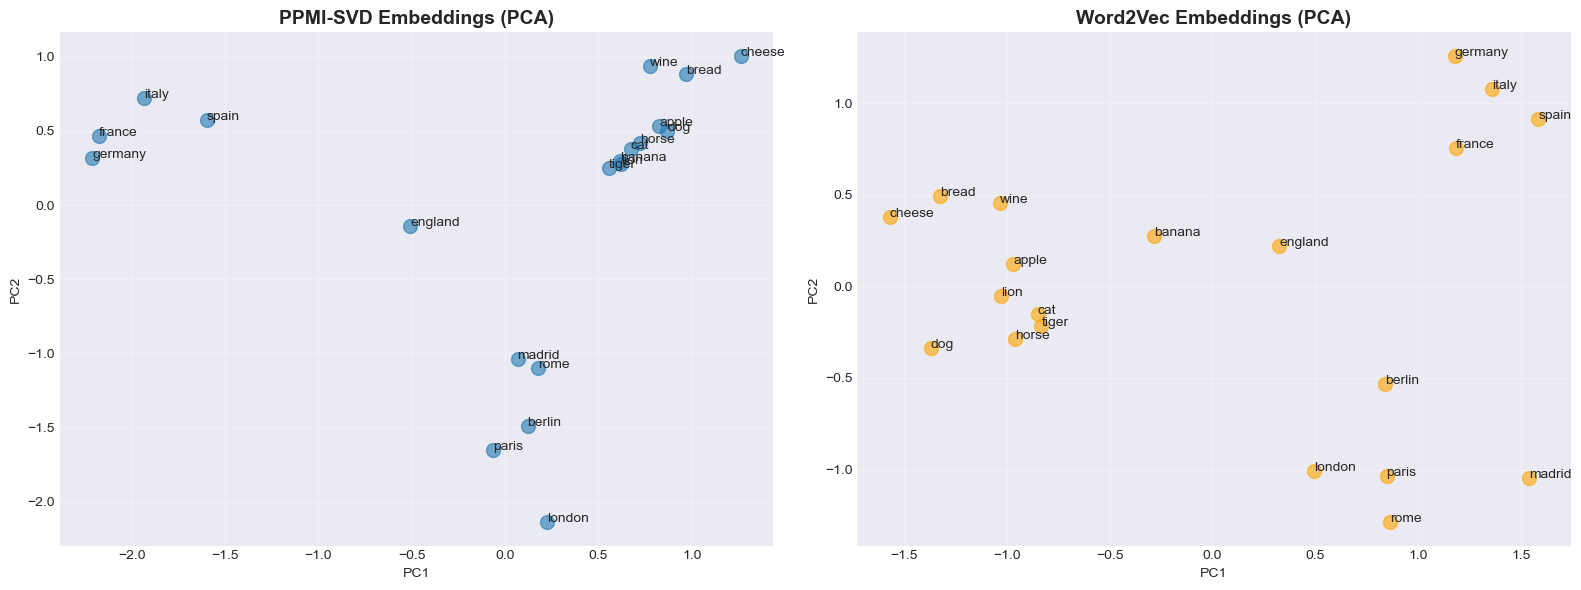

In [119]:
# Get embeddings for PPMI-SVD
ppmi_vectors = np.array([ppmi_model.get_embedding(w) for w in valid_words])
ppmi_2d = ppmi_model.project_to_2d(ppmi_vectors, method='pca')

# Get embeddings for Word2Vec
w2v_indices = [w2v_model.tokenizer.word2idx[w] for w in valid_words]
w2v_vectors = np.array([w2v_model.get_embedding(idx) for idx in w2v_indices])
w2v_2d = w2v_model.project_to_2d(w2v_vectors, method='pca')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PPMI-SVD
axes[0].scatter(ppmi_2d[:, 0], ppmi_2d[:, 1], alpha=0.6, s=100)
for i, word in enumerate(valid_words):
    axes[0].annotate(word, (ppmi_2d[i, 0], ppmi_2d[i, 1]), fontsize=10)
axes[0].set_title('PPMI-SVD Embeddings (PCA)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(True, alpha=0.3)

# Word2Vec
axes[1].scatter(w2v_2d[:, 0], w2v_2d[:, 1], alpha=0.6, s=100, color='orange')
for i, word in enumerate(valid_words):
    axes[1].annotate(word, (w2v_2d[i, 0], w2v_2d[i, 1]), fontsize=10)
axes[1].set_title('Word2Vec Embeddings (PCA)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Embedding Norm Distribution

Compare the distribution of embedding norms.

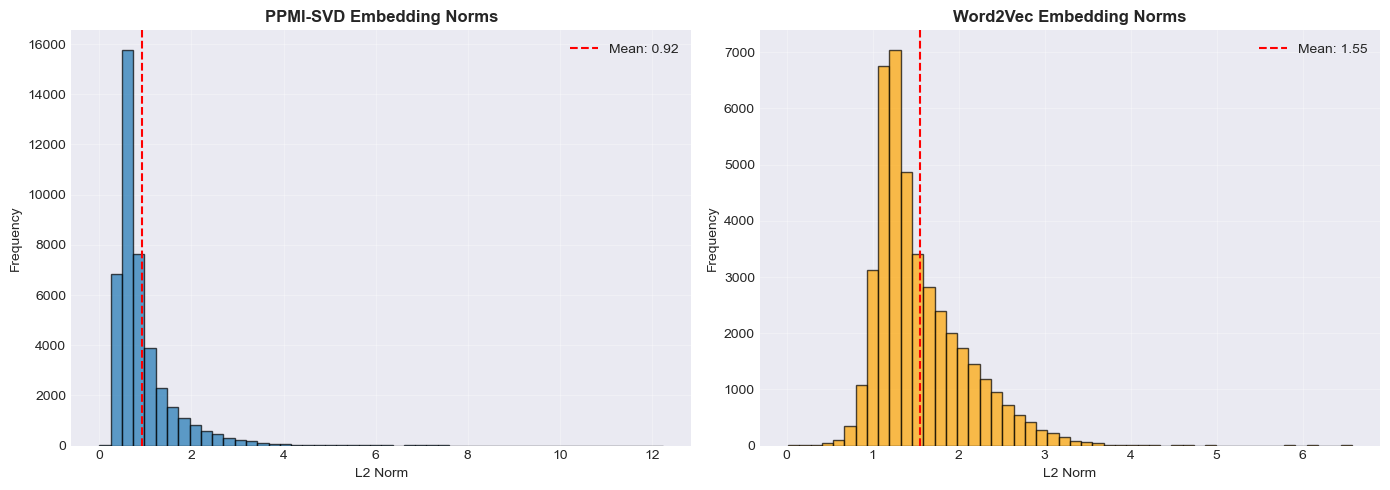

In [120]:
# Compute norms
ppmi_norms = np.linalg.norm(ppmi_model.embeddings, axis=1)
w2v_norms = np.linalg.norm(w2v_model.W, axis=1)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(ppmi_norms, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(ppmi_norms.mean(), color='red', linestyle='--', label=f'Mean: {ppmi_norms.mean():.2f}')
axes[0].set_title('PPMI-SVD Embedding Norms', fontsize=12, fontweight='bold')
axes[0].set_xlabel('L2 Norm')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(w2v_norms, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1].axvline(w2v_norms.mean(), color='red', linestyle='--', label=f'Mean: {w2v_norms.mean():.2f}')
axes[1].set_title('Word2Vec Embedding Norms', fontsize=12, fontweight='bold')
axes[1].set_xlabel('L2 Norm')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Interactive Exploration

Try your own similarity queries!

In [121]:
def explore_word(word, top_k=10):
    """Explore a word in both embedding models."""
    print(f"\n{'='*70}")
    print(f"Exploring: '{word}'")
    print(f"{'='*70}")
    
    # PPMI-SVD
    if word in ppmi_model.word2idx:
        similar = ppmi_model.most_similar(word, top_k=top_k)
        print(f"\nPPMI-SVD (top {top_k}):")
        for i, (w, score) in enumerate(similar, 1):
            print(f"  {i:2d}. {w:20s} {score:.4f}")
    else:
        print(f"\nPPMI-SVD: '{word}' not in vocabulary")
    
    # Word2Vec
    if word in w2v_model.tokenizer.word2idx:
        word_idx = w2v_model.tokenizer.word2idx[word]
        similar = w2v_model.most_similar(word_idx, top_k=top_k)
        print(f"\nWord2Vec (top {top_k}):")
        for i, (idx, score) in enumerate(similar, 1):
            w = w2v_model.tokenizer.idx2word[idx]
            print(f"  {i:2d}. {w:20s} {score:.4f}")
    else:
        print(f"\nWord2Vec: '{word}' not in vocabulary")

# Try different words
explore_word("king")
explore_word("computer")
explore_word("happy")


Exploring: 'king'

PPMI-SVD (top 10):
   1. queen                0.6189
   2. prince               0.6128
   3. reigning             0.6107
   4. majesty              0.6094
   5. throne               0.5982
   6. reign                0.5916
   7. nebuchadnezzar       0.5593
   8. edom                 0.5415
   9. highness             0.5394
  10. kings                0.5372

Word2Vec (top 10):
   1. emperor              0.8843
   2. judah                0.8706
   3. jehovah              0.8694
   4. jacob                0.8665
   5. matthew              0.8593
   6. caesar               0.8583
   7. pharaoh              0.8581
   8. paul                 0.8570
   9. isaac                0.8566
  10. lk                   0.8554

Exploring: 'computer'

PPMI-SVD (top 10):
   1. computers            0.6338
   2. pc                   0.6251
   3. desktop              0.6178
   4. printer              0.5860
   5. laptop               0.5853
   6. software             0.5616
   7. usb     